<a href="https://colab.research.google.com/github/ShawnLiu119/NLP_Bank_Complaint_Classification/blob/main/CustomerComplaint_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Customer Complaint Classification - NLP Topic Modelling**

In [1]:
import json #data format
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import os

# Load English tokenizer, tagger, parser and NER
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

**Named entity recognition (NER)** is a natural language processing (NLP) method that extracts information from text. NER involves detecting and categorizing important information in text known as named entities.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd

/root


In [4]:
folder = "/content/drive/MyDrive/kaggle_data/complaints"
file = "complaints-2021-05-14_08_16_.json"

path = os.path.join(folder, file)

#open JSON file
f = open(path)
data = json.load(f)

type(data)

list

In [5]:
df=pd.json_normalize(data)
#convert a list of dictionary (loaded from JSON file) into a flat table, missmatch part will return NaN, use this function to convert to structrual data

In [6]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
def value_counts(df, cols):
  for col in cols:
    print(f'\n columns {col}')
    print(df[col].value_counts())

cols = ['_source.issue', '_source.product', '_source.sub_product']
value_counts(df, cols)


 columns _source.issue
_source.issue
Loan modification,collection,foreclosure                                           9743
Managing an account                                                                7410
Loan servicing, payments, escrow account                                           5360
Problem with a purchase shown on your statement                                    4055
Account opening, closing, or management                                            3879
                                                                                   ... 
Advertising, marketing or disclosures                                                 1
Overdraft, savings or rewards features                                                1
Was approved for a loan, but didn't receive the money                                 1
Problem with an overdraft                                                             1
Money was taken from your bank account on the wrong day or for the wrong amount   

### Data Preprocessing

1. rename columns after json normalization (flat table)
2. impute "complaint" column by removing
3. Lower case / punctuation, remove text in square bracket, remove words containing numbers??? why
4. POS tags to get relevant words from the texts. Using Nouns just
5. Lemmatize the text

Reference:
https://www.analyticsvidhya.com/blog/2020/07/part-of-speechpos-tagging-dependency-parsing-and-constituency-parsing-in-nlp/#:~:text=Part%2Dof%2DSpeech%20(POS)%20tagging%20is%20a%20preprocessing,each%20word%20in%20a%20sentence.

**POS - Part-of-Speech Tagging** <br>
Part-of-Speech (POS) tagging is a natural language processing technique that involves assigning specific grammatical categories or labels (such as nouns, verbs, adjectives, adverbs, pronouns, etc.) to individual words within a sentence <br>
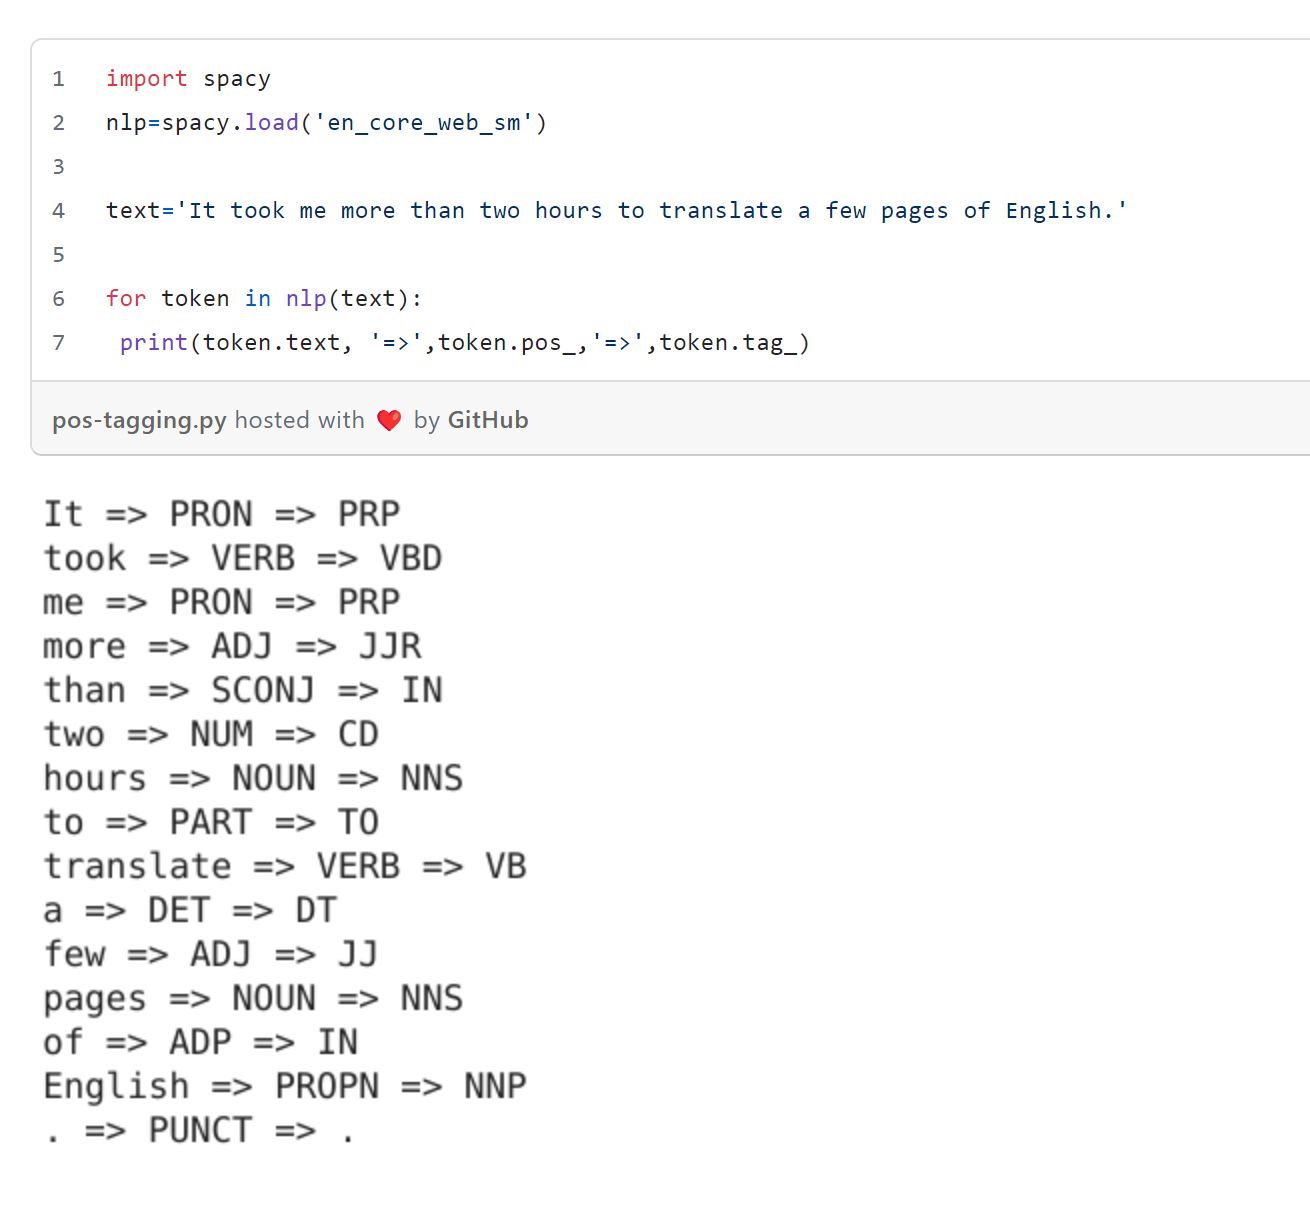

**Dependency Parsing** <br>
Dependency parsing is the process of analyzing the grammatical structure of a sentence based on the dependencies between the words in a sentence. <br>
**head**
**dependent/child** is associated with or based on head
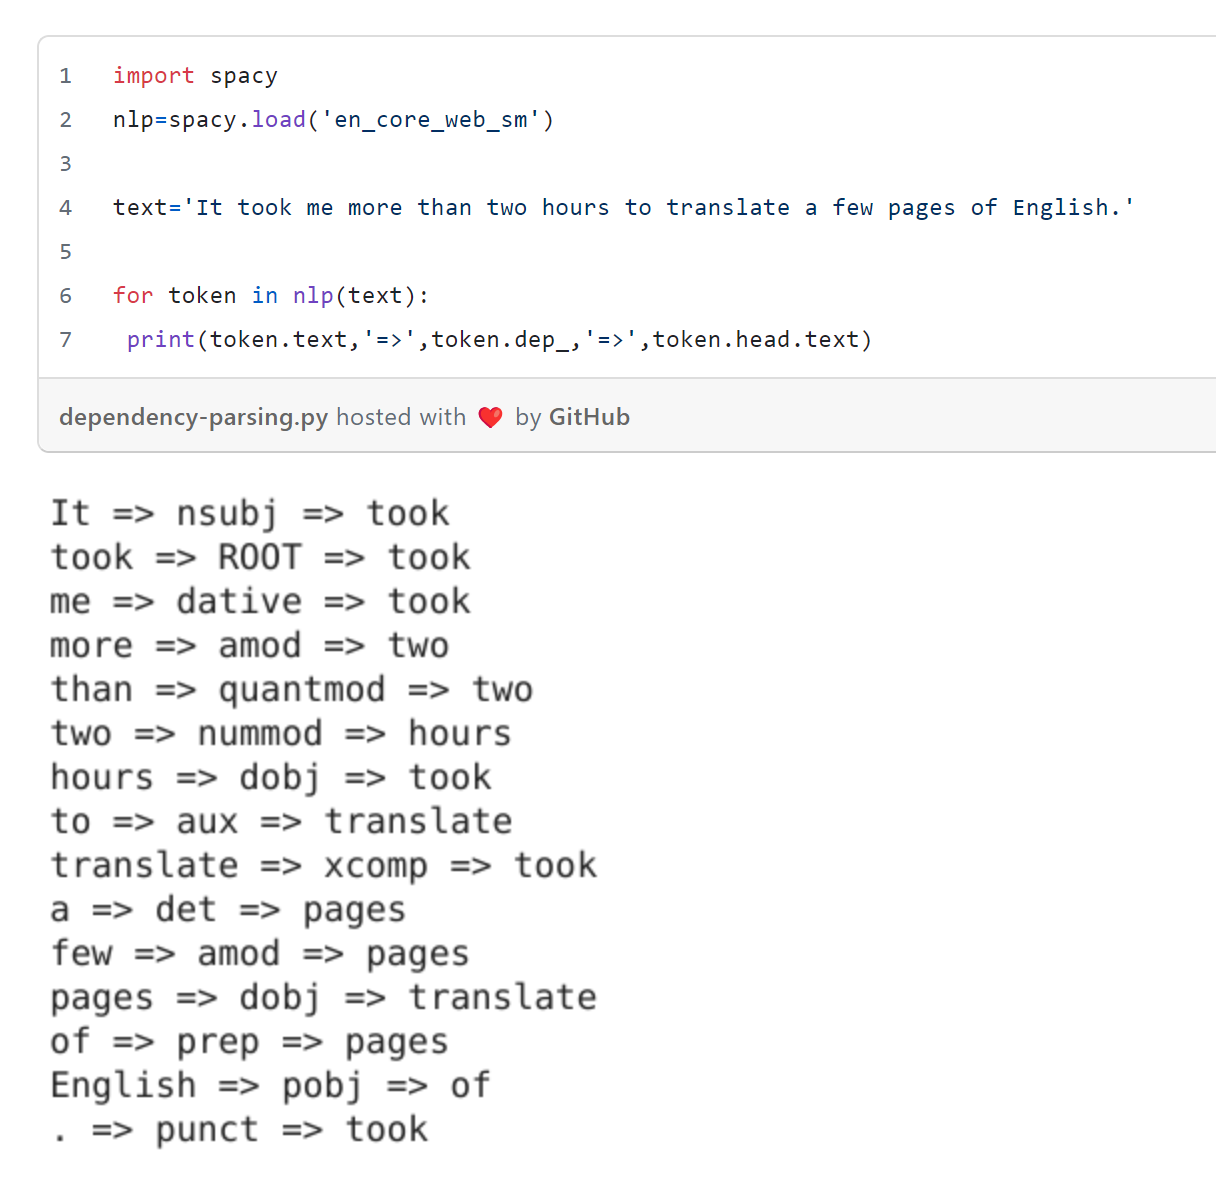


**Constituency Parsing Aid** <br>

Constituency Parsing is the process of analyzing the sentences by breaking down it into sub-phrases also known as constituents. These sub-phrases belong to a specific category of grammar like NP (noun phrase) and VP(verb phrase). <br>
NP: Noun Phase <br>
VP: Verb Phase <br>
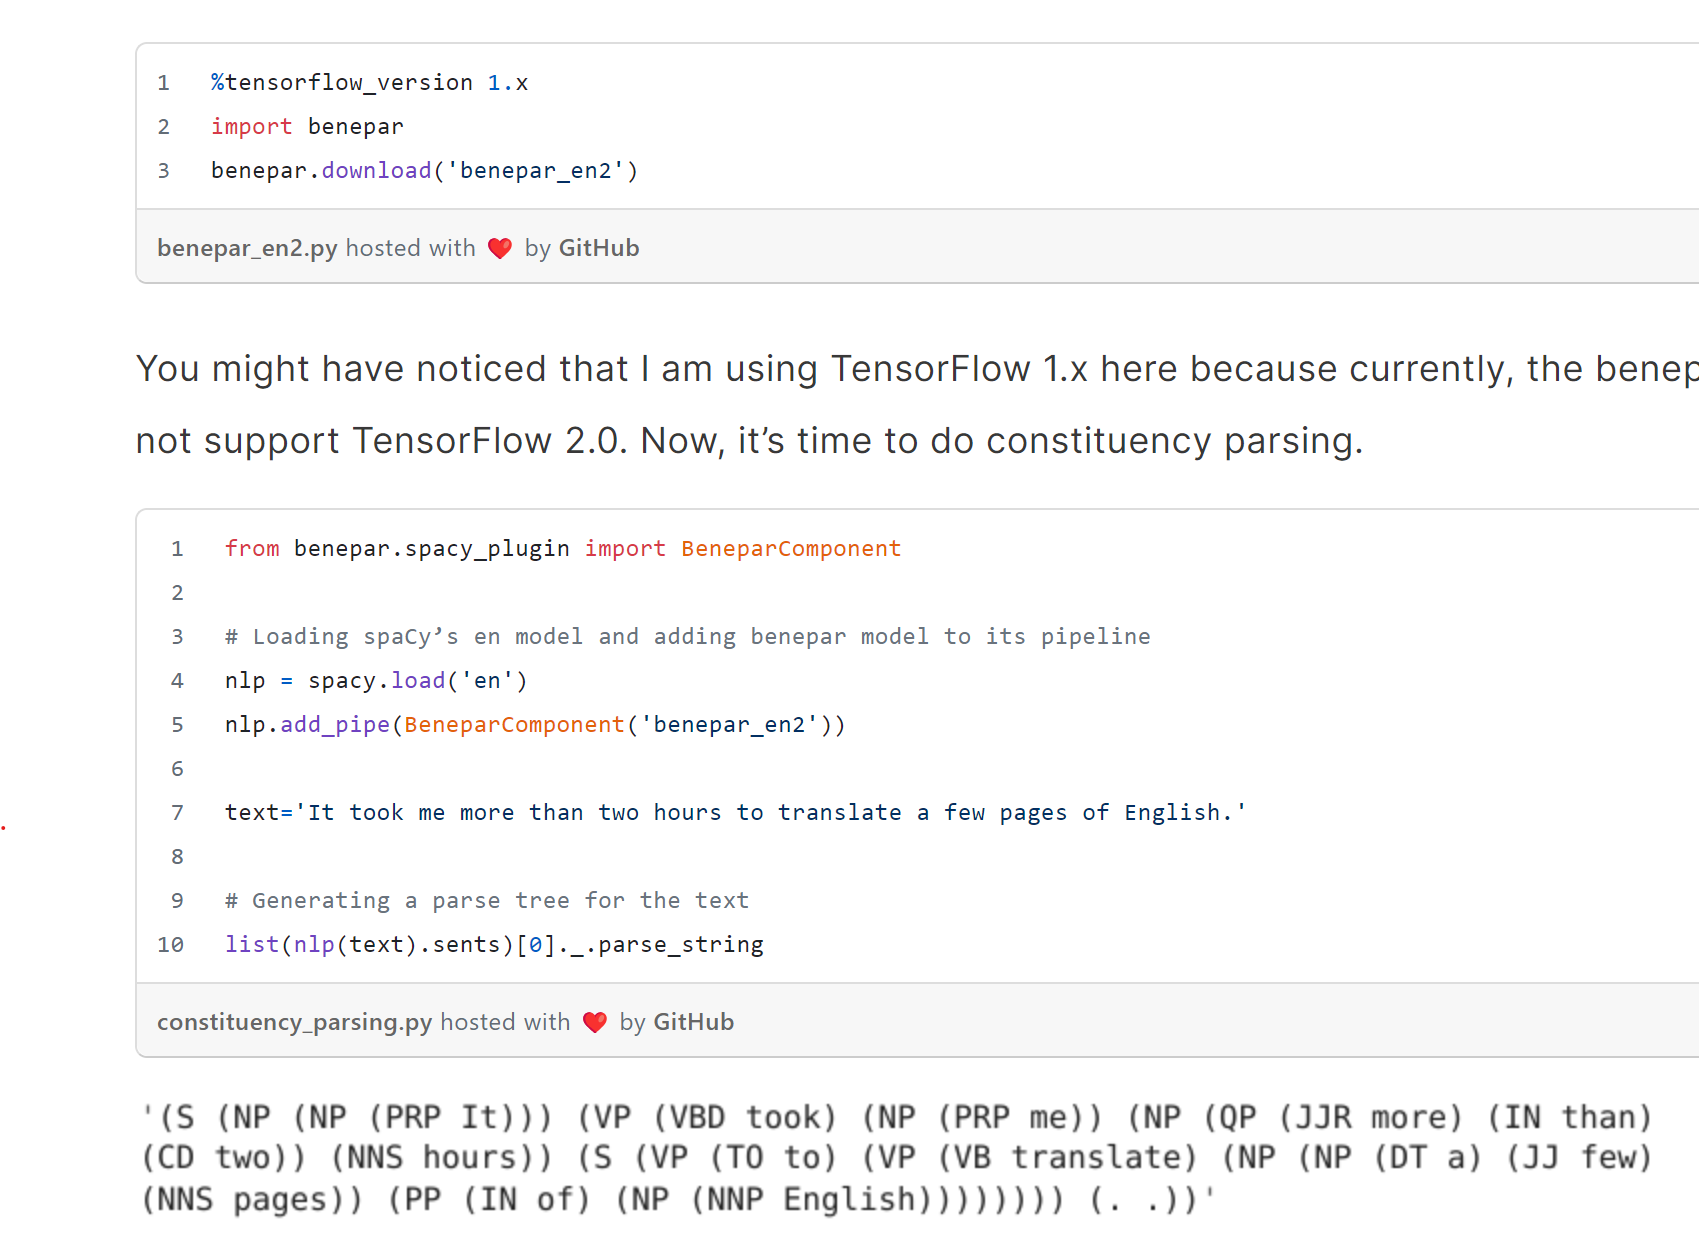

In [9]:
#Assigning new column names
df.columns = ["index","type","id","score","tags","zip_code","complaint_id","issue","date_received","state",
              "consumer_disputed","product","company_response","company","submitted_via","date_sent_to_company",
              "company_public_response","sub_product","timely","complaint_what_happened","sub_issue","consumer_consent_provided"]

In [10]:
#Assigning nan in place of blanks in the complaints column(complaint_what_happened)
df[df['complaint_what_happened']==''] = np.nan

In [11]:
#because we are analyzing the complaint, we will remove all rows where complaints colum is nan, [no data for analysis]
df = df.dropna(subset=['complaint_what_happened'])

df.shape

(21072, 22)

In [12]:
import re, nltk, spacy, string
pd.options.mode.chained_assignment = None
df.complaint_what_happened=df.complaint_what_happened.astype(str)
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_clean = pd.DataFrame(df.complaint_what_happened.apply(lambda x: clean_text(x)))

The regular expression \[.*?\] is used to match any text that is enclosed within square brackets. Let's break down the components of this regular expression:

1. **\[**: The backslash \ is an escape character that allows us to treat the following character as a literal. Here, it is escaping the opening square bracket [, so it matches a literal [.

2. **.*?**: This part consists of three characters:

 - .: This matches any character except a newline.

 - *: This is a quantifier that matches 0 or more occurrences of the preceding element (which is . in this case). This means it will match as many characters as possible.

 - ?: This makes the preceding quantifier (* in this case) non-greedy (or lazy). By default, * is greedy, meaning it will match as much text as possible. Adding ? makes it match as little text as possible, which is useful to ensure it stops at the first closing bracket ] rather than matching all the way to the last closing bracket in the text.
3. **\]**: Similar to \[, the backslash \ here escapes the closing square bracket ], so it matches a literal ].

**\: escape a string** -- Any quote that is preceded by a slash is escaped, and understood to be part of the value of the string.

The expression **[%s]' % re.escape(string.punctuation)** is used to create a regular expression pattern that matches any character in the string.punctuation set. Let's break this down step by step:

**string.punctuation**: This is a string constant in the string module of Python. It contains all the punctuation characters, <br>
output: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

**re.escape(string.punctuation)**: The re.escape function is used to escape all the characters in string.punctuation that have special meanings in regular expressions. This is necessary because punctuation characters like ., *, ?, [ and ] are special characters in regular expressions and need to be escaped to be treated as literal characters. The result of re.escape(string.punctuation) is: <br>
output:!"#\$%&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}~

**[%s]' % re.escape(string.punctuation)**: This uses Python's string formatting to insert the escaped punctuation characters into a character class. The %s (*The %s operator lets you add a value into a Python string. The %s signifies that you want to add a string value into a string*) is replaced by the result of re.escape(string.punctuation). The character class [...] matches any single character contained within the brackets. Therefore, the final regular expression pattern is:<br>
output: [!"#\$%&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}~]

The regular expression r'\w*\d\w*' is designed to match any string that contains at least one digit (\d) and may have word characters (\w) before and after the digit. Let's break down the components of this regular expression:

1. \w*:

 - \w: This matches any word character (alphanumeric characters and underscores), equivalent to [a-zA-Z0-9_].
 - *: This quantifier means "zero or more" of the preceding element (\w in this case). So, \w* matches any sequence of word characters, including an empty sequence.
2. \d:
 - \d: This matches any digit, equivalent to [0-9].
3. \w* (again):
 - This is the same as the first part, matching any sequence of word characters (including an empty sequence) following the digit.

In summary, r'\w*\d\w*' matches a string that:
- May start with zero or more word characters.
- Contains at least one digit.
- May end with zero or more word characters.

**Lemmatization**
sort words by grouping inflected or variant forms of the same word.

In [13]:
#Function to Lemmatize the texts
def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent) #use " "space to join a lit of lemmatized words

In [14]:
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [15]:
#Creating a dataframe that will have only the complaints and the lemmatized complaints.
import en_core_web_sm
nlp = en_core_web_sm.load()
df_clean["Complaint_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



In [16]:
df_clean.head()

,complaint_what_happened,Complaint_lemmatize
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


'''One thing to notice is unlike verbs and common nouns, there's no clear base form of a personal pronoun.
Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"?
spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.'''

**Chunking** <br>
Chunking in NLP is a process to take small pieces of information and group them into large units. The primary use of Chunking is making groups of "noun phrases

Chunking is a Natural Language Processing (NLP) technique that **breaks down sentences into phrases that are more useful than single words**. It involves analyzing a sentence to identify constituents like noun groups, verbs, and verb groups. Chunking can be done in two ways: chunking up and chunking down:

**Chunking up**
Makes language more abstract and increases the chances of agreement. For example, asking "for what purpose cars?" may result in the answer "transport", which is a higher chunk and more abstract.

**Chunking down**
Looks for specific details that may have been missing in the chunk up. For example, asking "what specifically about a car?" may result in smaller pieces of information about a car.

**Chunking works on top of POS tagging, using POS-tags as input and providing chunks as output. A standard set of chunk tags include Noun Phrase (NP) and Verb Phrase (VP). **



In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
#Here we are using only noun, singular as we have already lemmatized the texts.
import pandas as pd
from textblob import TextBlob

def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

def get_adjectives(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"]) ##NN noun

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_adjectives(x['Complaint_lemmatize']), axis=1)


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************



MissingCorpusError: 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.


**TextBlob** is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

### EDA